# Project 4 – Predicting a Continuous Target with Regression (Titanic)  
Author: Beth Spornitz
Date: November 6, 2025

Introduction-------


In [14]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling & ML tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Optional: improve DataFrame precision display
pd.options.display.precision = 3



## Section 1: Import and Inspect the Data

Load the Titanic dataset and confirm it’s structured correctly.

In [15]:
# Load Titanic dataset from seaborn and verify
titanic = sns.load_dataset("titanic")
titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.250,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.925,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.100,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.050,S,Third,man,True,NaN,Southampton,no,True


## Section 2: Data Exploration and Preparation

- Impute missing values for age using median  
- Drop rows with missing fare  
- Create `family_size = sibsp + parch + 1`  
- Optional: convert categorical columns (sex, embarked) if you want them later


Columns: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']
Shape: (891, 15)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
survived,891.0,NaN,NaN,NaN,0.384,0.487,0.0,0.0,0.0,1.0,1.0
pclass,891.0,NaN,NaN,NaN,2.309,0.836,1.0,2.0,3.0,3.0,3.0
sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,714.0,NaN,NaN,NaN,29.699,14.526,0.42,20.125,28.0,38.0,80.0
sibsp,891.0,NaN,NaN,NaN,0.523,1.103,0.0,0.0,0.0,1.0,8.0
parch,891.0,NaN,NaN,NaN,0.382,0.806,0.0,0.0,0.0,0.0,6.0
fare,891.0,NaN,NaN,NaN,32.204,49.693,0.0,7.91,14.454,31.0,512.329
embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class,891,3,Third,491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
who,891,3,man,537,NaN,NaN,NaN,NaN,NaN,NaN,NaN


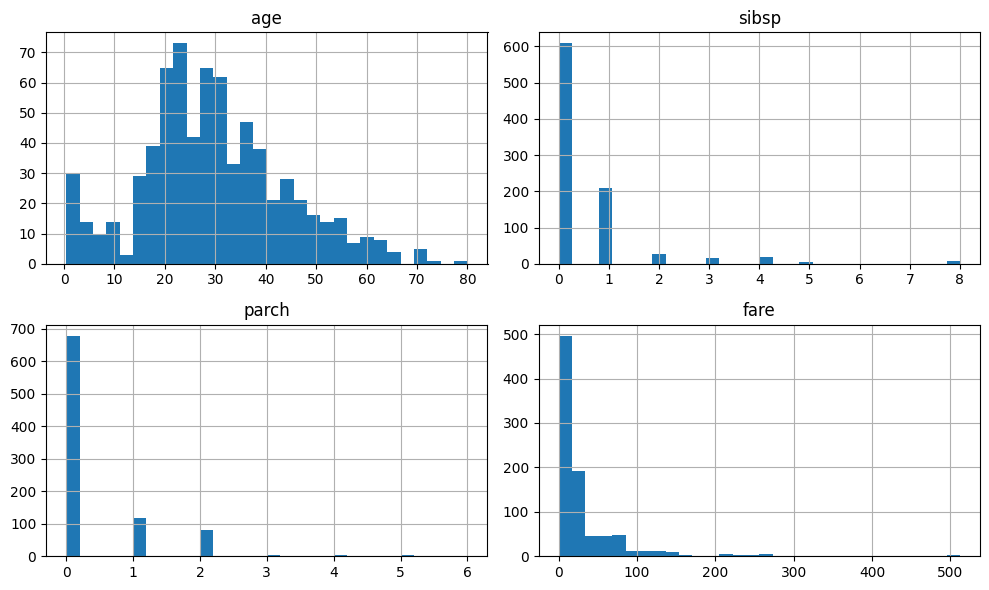

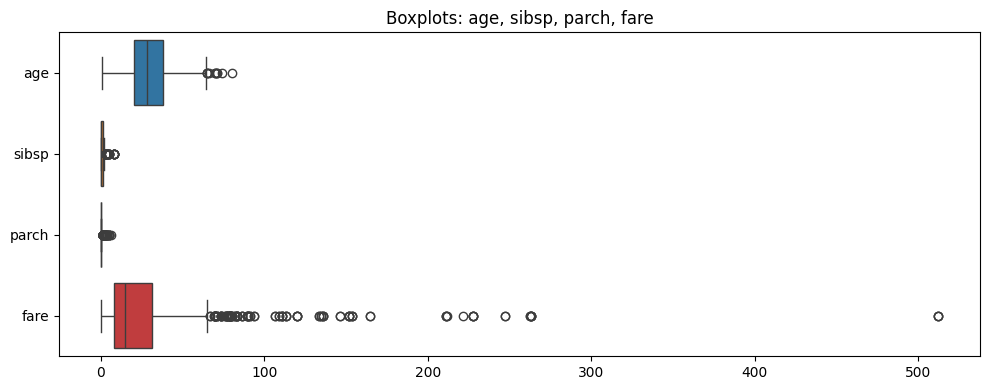

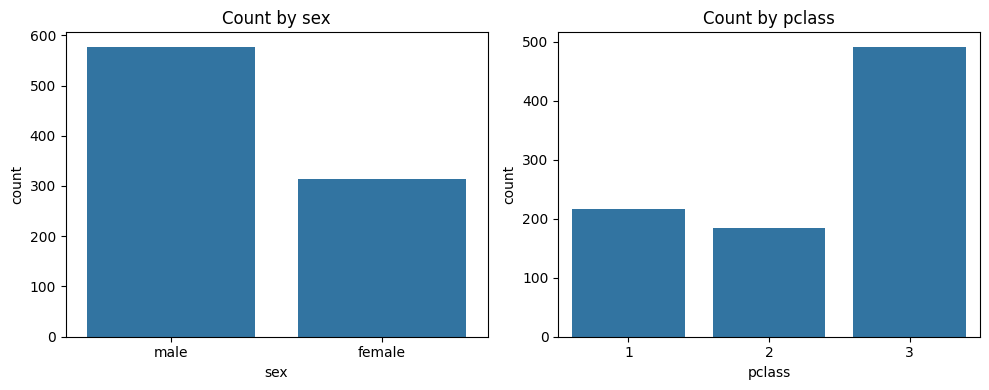

In [16]:
# Section 2.1 — Explore data patterns and distributions

print("Columns:", titanic.columns.tolist())
print("Shape:", titanic.shape)

# Quick overview of numeric columns
display(titanic.describe(include='all').T)

# Histograms for numeric features (including fare target)
_ = titanic[['age','sibsp','parch','fare']].hist(figsize=(10, 6), bins=30)
plt.tight_layout()
plt.show()

# Boxplots to scan for outliers (age, sibsp, parch, fare)
plt.figure(figsize=(10, 4))
sns.boxplot(data=titanic[['age','sibsp','parch','fare']], orient='h')
plt.title("Boxplots: age, sibsp, parch, fare")
plt.tight_layout()
plt.show()

# Optional categorical quick looks (kept light for regression context)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(data=titanic, x='sex', ax=axes[0])
axes[0].set_title('Count by sex')
sns.countplot(data=titanic, x='pclass', ax=axes[1])
axes[1].set_title('Count by pclass')
plt.tight_layout()
plt.show()


In [17]:
# Section 2.2 — Handle missing values and clean data

# 1) Impute age with median (FIX: avoid chained assignment warning)
titanic['age'] = titanic['age'].fillna(titanic['age'].median())

# 2) Drop rows with missing fare (target for regression)
titanic = titanic.dropna(subset=['fare'])

# 3) Feature engineering: family_size = sibsp + parch + 1
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# 4) OPTIONAL encoding for Case 4 (sex -> numeric) — minimal, allowed by instructions
titanic['sex_num'] = titanic['sex'].map({'male': 0, 'female': 1}).astype('float')

# Sanity checks
print("Any NA left in age?", titanic['age'].isna().sum())
print("Any NA left in fare?", titanic['fare'].isna().sum())
display(titanic[['age','sibsp','parch','family_size','sex','sex_num','fare']].head())


Any NA left in age? 0
Any NA left in fare? 0


,age,sibsp,parch,family_size,sex,sex_num,fare
0,22.0,1,0,2,male,0.0,7.250
1,38.0,1,0,2,female,1.0,71.283
2,26.0,0,0,1,female,1.0,7.925
3,35.0,1,0,2,female,1.0,53.100
4,35.0,0,0,1,male,0.0,8.050


## Section 3: Feature Selection and Justification

### Case 1: age only


In [18]:
X1 = titanic[['age']]
y1 = titanic['fare']


### Case 2: family_size only


In [19]:
X2 = titanic[['family_size']]
y2 = titanic['fare']


### Case 3: age + family_size


In [20]:
X3 = titanic[['age', 'family_size']]
y3 = titanic['fare']


### Case 4: Sex


In [21]:
X4 = titanic[['sex_num']]
y4 = titanic['fare']


In [22]:
# Quick shapes check
print("Case 1 shapes:", X1.shape, y1.shape)
print("Case 2 shapes:", X2.shape, y2.shape)
print("Case 3 shapes:", X3.shape, y3.shape)
print("Case 4 shapes:", X4.shape, y4.shape)

Case 1 shapes: (891, 1) (891,)
Case 2 shapes: (891, 1) (891,)
Case 3 shapes: (891, 2) (891,)
Case 4 shapes: (891, 1) (891,)


**Reflection Questions:**
- Why might these features affect fare?
- List all available features:
- Which features could improve predictions and why?
- How many variables are in your Case 4?
- Why did you choose those variables?


## Section 4: Train a Regression Model (Linear Regression)


### 4.1 Split the Data


In [23]:
# Section 4.1 — Split the Data

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=123)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=123)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=123)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=123)

print("Train/Test sizes:",
      len(X1_train), len(X1_test),
      len(X2_train), len(X2_test),
      len(X3_train), len(X3_test),
      len(X4_train), len(X4_test))



Train/Test sizes: 712 179 712 179 712 179 712 179


### 4.2 Train and Evaluate Linear Regression Models (all 4 cases)

We'll use a more concise approach - create each model and immediately call the fit() method.


In [24]:
# Section 4.2 — Train Linear Regression models & predict (Cases 1–4)

lr_model1 = LinearRegression().fit(X1_train, y1_train)
lr_model2 = LinearRegression().fit(X2_train, y2_train)
lr_model3 = LinearRegression().fit(X3_train, y3_train)
lr_model4 = LinearRegression().fit(X4_train, y4_train)

# Predictions
y_pred_train1 = lr_model1.predict(X1_train)
y_pred_test1  = lr_model1.predict(X1_test)

y_pred_train2 = lr_model2.predict(X2_train)
y_pred_test2  = lr_model2.predict(X2_test)

y_pred_train3 = lr_model3.predict(X3_train)
y_pred_test3  = lr_model3.predict(X3_test)

y_pred_train4 = lr_model4.predict(X4_train)
y_pred_test4  = lr_model4.predict(X4_test)


### 4.3 Report Performance


In [26]:
def report_case(name, y_train, y_pred_train, y_test, y_pred_test):
    # Training and Test R²
    print(f"{name} — Training R²: {r2_score(y_train, y_pred_train):.3f}")
    print(f"{name} — Test     R²: {r2_score(y_test,  y_pred_test):.3f}")
    
    # Test RMSE (manual calculation because squared=False is not supported)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"{name} — Test   RMSE: {rmse:.2f}")
    
    # Test MAE
    print(f"{name} — Test    MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
    print()

report_case("Case 1 (age)",              y1_train, y_pred_train1, y1_test, y_pred_test1)
report_case("Case 2 (family_size)",      y2_train, y_pred_train2, y2_test, y_pred_test2)
report_case("Case 3 (age + family_size)",y3_train, y_pred_train3, y3_test, y_pred_test3)
report_case("Case 4 (sex_num)",          y4_train, y_pred_train4, y4_test, y_pred_test4)



Case 1 (age) — Training R²: 0.010
Case 1 (age) — Test     R²: 0.003
Case 1 (age) — Test   RMSE: 37.97
Case 1 (age) — Test    MAE: 25.29

Case 2 (family_size) — Training R²: 0.050
Case 2 (family_size) — Test     R²: 0.022
Case 2 (family_size) — Test   RMSE: 37.61
Case 2 (family_size) — Test    MAE: 25.03

Case 3 (age + family_size) — Training R²: 0.073
Case 3 (age + family_size) — Test     R²: 0.050
Case 3 (age + family_size) — Test   RMSE: 37.08
Case 3 (age + family_size) — Test    MAE: 24.28

Case 4 (sex_num) — Training R²: 0.024
Case 4 (sex_num) — Test     R²: 0.099
Case 4 (sex_num) — Test   RMSE: 36.10
Case 4 (sex_num) — Test    MAE: 24.24



#### Section 4 Reflection Questions

Compare the train vs test results for each.

Did Case 1 overfit or underfit? Explain:  
Did Case 2 overfit or underfit? Explain:  
Did Case 3 overfit or underfit? Explain:  
Did Case 4 overfit or underfit? Explain:  

Adding Age  
Did adding age improve the model:  
Propose a possible explanation (consider how age might affect ticket price, and whether the data supports that):  

Worst  
Which case performed the worst:  
How do you know:  
Do you think adding more training data would improve it (and why/why not):  

Best  
Which case performed the best:  
How do you know:  
Do you think adding more training data would improve it (and why/why not):  


## Section 5. Compare Alternative Models

Choose the best case model from the four cases. Use that model to continue to explore additional continuous prediction models.


### 5.1 Ridge Regression (L2 penalty)


In [ ]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X1_train, y1_train)
y_pred_ridge = ridge_model.predict(X1_test)


### 5.2 Elastic Net (L1 + L2 combined)


In [ ]:
elastic_model = ElasticNet(alpha=0.3, l1_ratio=0.5)
elastic_model.fit(X1_train, y1_train)
y_pred_elastic = elastic_model.predict(X1_test)


### 5.3 Polynomial Regression


In [ ]:
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X1_train)
X_test_poly = poly.transform(X1_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y1_train)
y_pred_poly = poly_model.predict(X1_test_poly)


### 5.4 Visualize Polynomial Cubic Fit (for 1 input feature)


In [ ]:
plt.scatter(X1_test, y1_test, label='Actual')
plt.scatter(X1_test, y_pred_poly, label='Predicted (Poly)')
plt.legend()
plt.title("Polynomial Regression: Age vs Fare")
plt.show()


### 5.4 Reflections

What patterns does the cubic model seem to capture:  
Where does it perform well or poorly:  
Did the polynomial fit outperform linear regression:  
Where (on the graph or among which kinds of data points) does it fit best:  


### 5.4 Compare All Models


In [ ]:
def report(name, y_true, y_pred):
    print(f"{name} R²: {r2_score(y_true, y_pred):.3f}")
    print(f"{name} RMSE: {mean_squared_error(y_true, y_pred, squared=False):.2f}")
    print(f"{name} MAE: {mean_absolute_error(y_true, y_pred):.2f}\n")

report("Linear", y1_test, y1_pred_test)
report("Ridge", y1_test, y_pred_ridge)
report("ElasticNet", y1_test, y_pred_elastic)
report("Polynomial", y1_test, y_pred_poly)


### 5.5 Visualize Higher Order Polynomial (for the same 1 input case)


In [ ]:
degree = 5  # try 4–8
poly_hi = PolynomialFeatures(degree=degree)
X_train_poly_hi = poly_hi.fit_transform(X1_train)
X_test_poly_hi = poly_hi.transform(X1_test)

poly_model_hi = LinearRegression()
poly_model_hi.fit(X_train_poly_hi, y1_train)
y_pred_poly_hi = poly_model_hi.predict(X_test_poly_hi)

plt.scatter(X1_test, y1_test)
plt.scatter(X1_test, y_pred_poly_hi)
plt.title(f"Polynomial Regression (degree={degree})")
plt.show()


## Section 6. Final Thoughts & Insights

### 6.1 Summarize Findings
What features were most useful?  
What regression model performed best?  
How did model complexity or regularization affect results?  

### 6.2 Discuss Challenges
Was fare hard to predict? Why?  
Did skew or outliers impact the models?  

### 6.3 Optional Next Steps
Try different features besides the ones used  
Try predicting age instead of fare  
Explore log transformation of fare to reduce skew  
